In [1]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

class CaptchaDatasetWithBBoxes(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Direct path to the specific data folder (train, val, or test)
            transform (callable, optional): Optional transform to be applied on images
        """
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.transform = transform
        
        self.image_list = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.png')])
        
        # Load labels if available
        self.labels_dict = {}
        labels_file = os.path.join(self.data_dir, 'labels.json')
        if os.path.exists(labels_file):
            with open(labels_file, 'r') as f:
                labels = json.load(f)
                self.labels_dict = {item['image_id']: item for item in labels}
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.image_list[idx]
        img_path = os.path.join(self.images_dir, img_name)
        
        # Load image as grayscale
        image = Image.open(img_path).convert('L')
        original_size = image.size  # (width, height)
        
        # Get image_id without extension
        image_id = os.path.splitext(img_name)[0]
        
        # Get labels if available
        label_info = self.labels_dict.get(image_id, {})
        
        # Extract captcha string and annotations
        captcha_string = label_info.get('captcha_string', '')
        annotations = label_info.get('annotations', [])
        
        # Process bounding boxes
        bboxes = []
        oriented_bboxes = []
        category_ids = []
        
        for annotation in annotations:
            # Regular bounding box [x1, y1, x2, y2]
            bbox = annotation.get('bbox', [])
            if bbox:
                bboxes.append(bbox)
            
            # Oriented bounding box [x1,y1,x2,y2,x3,y3,x4,y4]
            oriented_bbox = annotation.get('oriented_bbox', [])
            if oriented_bbox:
                oriented_bboxes.append(oriented_bbox)
            
            # Category ID (character class)
            category_id = annotation.get('category_id', -1)
            category_ids.append(category_id)
        
        # Convert to tensors
        bboxes = torch.tensor(bboxes, dtype=torch.float32) if bboxes else torch.empty((0, 4))
        oriented_bboxes = torch.tensor(oriented_bboxes, dtype=torch.float32) if oriented_bboxes else torch.empty((0, 8))
        category_ids = torch.tensor(category_ids, dtype=torch.long) if category_ids else torch.empty((0,), dtype=torch.long)
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
        
        sample = {
            'image': image,
            'image_id': image_id,
            'captcha_string': captcha_string,
            'bboxes': bboxes,  # Regular bounding boxes
            'oriented_bboxes': oriented_bboxes,  # Oriented bounding boxes
            'category_ids': category_ids,  # Character category IDs
            'num_objects': len(annotations),  # Number of characters
            'original_size': original_size  # (width, height)
        }
        
        return sample

# Custom collate function for bounding boxes
def collate_fn_with_bboxes(batch):
    """Custom collate function to handle variable-length bounding boxes"""
    images = torch.stack([item['image'] for item in batch])
    image_ids = [item['image_id'] for item in batch]
    captcha_strings = [item['captcha_string'] for item in batch]
    
    # Keep bounding boxes as lists since they have variable lengths
    bboxes = [item['bboxes'] for item in batch]
    oriented_bboxes = [item['oriented_bboxes'] for item in batch]
    category_ids = [item['category_ids'] for item in batch]
    num_objects = [item['num_objects'] for item in batch]
    original_sizes = [item['original_size'] for item in batch]
    
    return {
        'image': images,
        'image_id': image_ids,
        'captcha_string': captcha_strings,
        'bboxes': bboxes,
        'oriented_bboxes': oriented_bboxes,
        'category_ids': category_ids,
        'num_objects': num_objects,
        'original_size': original_sizes
    }

# Helper function to create dataloaders with bboxes
def get_dataloader_with_bboxes(data_folder, batch_size=32, shuffle=True):
    """
    Create dataloader that includes bounding box information
    """
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Create dataset
    dataset = CaptchaDatasetWithBBoxes(
        data_dir=data_folder,
        transform=transform
    )
    
    # Create dataloader with custom collate function
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        collate_fn=collate_fn_with_bboxes
    )
    
    return dataloader

# Visualization function with bounding boxes
def visualize_with_bboxes(batch, idx=0):
    """Visualize image with bounding boxes"""
    # Get image and denormalize
    img = batch['image'][idx].squeeze()
    img = img * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    
    # Get bounding boxes for this image
    bboxes = batch['bboxes'][idx]
    category_ids = batch['category_ids'][idx]
    captcha_string = batch['captcha_string'][idx]
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.imshow(img, cmap='gray')
    ax.set_title(f"CAPTCHA: {captcha_string}")
    
    # Draw bounding boxes
    for i, bbox in enumerate(bboxes):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        # Create rectangle
        rect = plt.Rectangle((x1, y1), width, height, 
                           linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add category ID as text
        if i < len(category_ids):
            ax.text(x1, y1-5, f'ID: {category_ids[i].item()}', 
                   color='red', fontsize=10, weight='bold')
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Number of characters: {len(bboxes)}")
    print(f"Bounding boxes shape: {bboxes.shape}")
    print(f"Category IDs: {category_ids.tolist()}")

Batch size: 4
Image shape: torch.Size([4, 1, 160, 640])


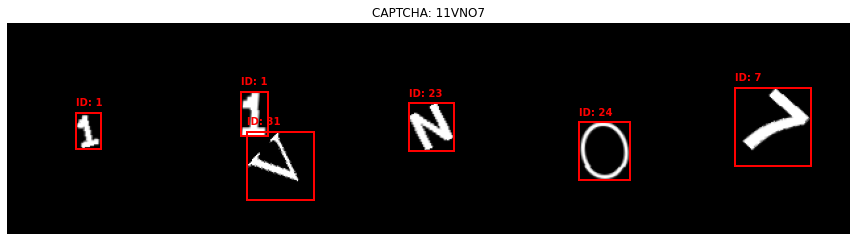

Number of characters: 6
Bounding boxes shape: torch.Size([6, 4])
Category IDs: [1, 1, 31, 23, 24, 7]
Image 0: '11VNO7' has 6 characters
  Bboxes shape: torch.Size([6, 4])
Image 1: '3P' has 2 characters
  Bboxes shape: torch.Size([2, 4])
Image 2: 'GOPQ' has 4 characters
  Bboxes shape: torch.Size([4, 4])
Image 3: 'S901' has 4 characters
  Bboxes shape: torch.Size([4, 4])


In [2]:
import os

# Base path to the dataset
base_path = '/home/utn/abap44us/Downloads/UTN-CV25-Captcha-Dataset/part2'

# Create dataloaders with bounding boxes
train_loader_bbox = get_dataloader_with_bboxes(os.path.join(base_path, 'train'), batch_size=4, shuffle=True)

# Test the dataloader
for batch in train_loader_bbox:
    print(f"Batch size: {len(batch['captcha_string'])}")
    print(f"Image shape: {batch['image'].shape}")
    
    # Visualize first image with bounding boxes
    visualize_with_bboxes(batch, idx=0)
    
    # Print info about bounding boxes
    for i in range(len(batch['captcha_string'])):
        print(f"Image {i}: '{batch['captcha_string'][i]}' has {batch['num_objects'][i]} characters")
        print(f"  Bboxes shape: {batch['bboxes'][i].shape}")
    
    break

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Weight Inititializeion with He-Method ) ---
def init_weights_kaiming(m):
    # use Kaiming init for conv/linear layers, set bias to zero
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    # batch/group norm: start with weight=1 and bias=0
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

#  Stem 
class Stem(nn.Module):
    """
    This is a small-image friendly stem that mimics the res-net18 style stem.

    Tradition ResNet stem:
        # self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=7, stride=2, padding=3, bias=False)
        # self.bn   = nn.BatchNorm2d(out_ch)
        # self.relu = nn.ReLU(inplace=True)
        # self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    Compared to traditional. resnet 18 this  replace 7x7 s2 + maxpool with 3×(3x3) conv stack and delay the first downsample.
    Goal: retain fineer details early in network
    """
    # def __init__(self, in_ch=3, out_ch=64):  # RGB input channels
    def __init__(self, in_ch=1, out_ch=64):    # Grayscale Input Channels
        super().__init__()

        # --- New small-image stem ---
        self.conv1 = nn.Conv2d(in_ch, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)
        self.act1  = nn.SiLU(inplace=True)  # see https://arxiv.org/pdf/1710.05941

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(32)
        self.act2  = nn.SiLU(inplace=True)

        self.conv3 = nn.Conv2d(32, out_ch, kernel_size=3, stride=2, padding=1, bias=False)  # first downsample here
        self.bn3   = nn.BatchNorm2d(out_ch)
        self.act3  = nn.SiLU(inplace=True)

        # Initialize weights of conv layers via He_Init Strategy
        for m in [self.conv1, self.conv2, self.conv3]:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        for b in [self.bn1, self.bn2, self.bn3]:
            nn.init.constant_(b.weight, 1.0)
            nn.init.constant_(b.bias, 0.0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        return x  # 160x640 -> 80x320 (H×W)

#  Residual Block used for resnet
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1, dilation=1 , downsample=None):
        super().__init__()
        """
        [IMPROVEMENT] allow dilation to grow RF without more downsamples
        [IMPROVEMENT] SiLU activations for smoother gradients on OCR edges
        """
        padding = dilation
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride,
                               padding=padding, dilation=dilation, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.act   = nn.SiLU(inplace=True)  # was ReLU

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,
                               padding=padding, dilation=dilation, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.downsample = downsample   # <--- store it


        # Init
        for m in (self.conv1, self.conv2):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn1.weight, 1.0); nn.init.constant_(self.bn1.bias, 0.0)
        nn.init.constant_(self.bn2.weight, 1.0); nn.init.constant_(self.bn2.bias, 0.0)

    def forward(self, x):
        identity = x

        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:   # <--- apply projection if needed
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        return out

# ---------- ResNet-18 Backbone ----------
class ResNet18Backbone(nn.Module):
    """
    Backbone only (no GAP/FC).

    Old vanilla scales (for 640x160 W×H) were deeper OS; we keep higher spatial detail:
      stem  (s2) -> 80x320
      layer1 (s1) -> 80x320
      layer2 (s2) -> 40x160
      layer3 (s1, dil=2) -> 40x160
      layer4 (s1, dil=2) -> 40x160   (256 ch)  <-- feed to your head(s)

    Goal: better localization of small characters while keeping receptive field via dilation.
    """
    def __init__(self, in_ch=1, return_p3=True):
        super().__init__()
        self.stem = Stem(in_ch=in_ch, out_ch=64)
        self.in_ch = 64
        self.return_p3 = return_p3

        # layer1: stride=1
        self.layer1 = self._make_layer(ResidualBlock, 64,  blocks=2, stride=1, dilation=1)

        # layer2: stride=2 (downsample to ~1/4 overall)
        self.layer2 = self._make_layer(ResidualBlock, 128, blocks=2, stride=2, dilation=1)

        # layer3: keep resolution (stride=1) but expand RF with dilation
        self.layer3 = self._make_layer(ResidualBlock, 256, blocks=2, stride=1, dilation=2)

        # layer4: same resolution (stride=1) with dilation
        self.layer4 = self._make_layer(ResidualBlock, 256, blocks=2, stride=1, dilation=2)  # slimmer tail (256)

    def _make_layer(self, block, out_ch, blocks, stride, dilation):
        down = None
        in_ch = self.in_ch
    
        # Projection when spatial size or channels change
        if stride != 1 or in_ch != out_ch:
            down = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )
    
        layers = [block(in_ch, out_ch, stride=stride, dilation=dilation, downsample=down)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(block(out_ch, out_ch, stride=1, dilation=dilation, downsample=None))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.stem(x)         # -> 80x320
        x = self.layer1(x)      # -> 80x320
        x = self.layer2(x)     # -> 40x160
        x = self.layer3(x)     # -> 40x160
        x = self.layer4(x)     # -> 40x160
        return x
    


# if __name__ == "__main__":
#     dummy = torch.randn(1, 1, 160, 640)  # grayscale CAPTCHA
    
#     backbone = ResNet18Backbone(in_ch=1)
#     x = dummy
    
#     print("Input:", x.shape)
    
#     x = backbone.stem(x)
#     print("After Stem:", x.shape)
    
#     x = backbone.layer1(x)
#     print("After Layer1:", x.shape)
    
#     x = backbone.layer2(x)
#     print("After Layer2:", x.shape)
    
#     x = backbone.layer3(x)
#     print("After Layer3:", x.shape)
    
#     x = backbone.layer4(x)
#     print("After Layer4:", x.shape)


class YOLOv8Head(nn.Module):
    """
    YOLOv8-style detection head for CAPTCHA character detection
    
    Input: Feature maps from ResNet18 backbone (batch_size, 256, H, W)
    Output: Predictions (batch_size, height*width*(5 + num_classes))
           Format: [x, y, w, h, objectness, class_0, class_1, ...]
    """
    
    def __init__(self, in_channels=256, num_classes=37, height=10, width=40):
        super(YOLOv8Head, self).__init__()
        self.num_classes = num_classes
      
        self.height = height
        self.width = width
        
        # Output channels: bbox(4) + objectness(1) + classes(num_classes)
        self.output_channels = 5 + num_classes
        
        # Feature processing layers
        self.conv1 = nn.Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Final prediction layer
        self.pred_conv = nn.Conv2d(64, self.output_channels, kernel_size=1)
        
        # Adaptive pooling to ensure (height × width) output
        self.adaptive_pool = nn.AdaptiveAvgPool2d((height, width))
        # remove adaptive pool to consitent with resnet
      
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Feature maps from backbone (batch_size, 256, H, W)
            
        Returns:
            predictions: (batch_size, height*width*(5 + num_classes))
        """
        # Process features through conv layers
        x = F.relu(self.bn1(self.conv1(x)))  
        x = F.relu(self.bn2(self.conv2(x)))  
        x = F.relu(self.bn3(self.conv3(x)))  
        
        # Get predictions
        x = self.pred_conv(x)  # (batch_size, 5+num_classes, H, W)
        
        # Ensure fixed grid size
        x = self.adaptive_pool(x)  # (batch_size, 5+num_classes, height, width)
        # remove adapative pool to make flexible and compatible with resnet
        
        # Reshape for loss function
        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1)  # (batch_size, height, width, 5+num_classes)
        #x = x.view(batch_size, -1)  # (batch_size, height*width*(5+num_classes)) ---> changed to reshape
        x = x.reshape(batch_size, -1)
        
        return x

class ResNet18YOLO(nn.Module):
    """
    Full CAPTCHA solver backbone + YOLO head
    Hybrid approach: ResNet18-style backbone with dilations, YOLOv8-inspired detection head.
    
    Input:  (batch_size, 1, 160, 640)  grayscale CAPTCHA image
    Output: (batch_size, 10*10*(5 + num_classes))  detection grid
    """
    def __init__(self, grid_height, grid_width, num_classes=37):
        super(ResNet18YOLO, self).__init__()
        # backbone
        self.backbone = ResNet18Backbone(in_ch=1, return_p3=True)
        # head
        self.head = YOLOv8Head(in_channels=256, num_classes=num_classes, height=grid_height, width=grid_width)

    def forward(self, x):
        # Extract backbone features
        feats = self.backbone(x)              # (batch, 256, 40, 160)
        # YOLO-style detection
        preds = self.head(feats)              # (batch, 7*7*(5+num_classes))
        return preds

def decode_yolo_output(preds, num_classes=37, height=10, width=40, img_h=160, img_w=640, conf_thresh=0.5):
    """
    Decode YOLOv8Head predictions into bounding boxes and class labels.
    
    Args:
        preds: (batch_size, height*width*(5+num_classes)) flattened tensor
        num_classes: number of character classes
        height, width: grid dimensions (10x40 for your case)
        img_h, img_w: input image dimensions (160x640)
        conf_thresh: confidence threshold for objectness
        
    Returns:
        List[ List[dict] ] where each inner list is detections for one image:
        {
            "x_center": float,
            "y_center": float,
            "width": float,
            "height": float,
            "class": int,
            "confidence": float
        }
    """
    batch_size = preds.shape[0]
    cell_h = img_h / height
    cell_w = img_w / width
    
    detections = []
    
    for b in range(batch_size):
        img_preds = preds[b].view(height, width, 5 + num_classes)  # (H, W, 5+num_classes)
        
        boxes = []
        for i in range(height):
            for j in range(width):
                tx, ty, tw, th, obj_conf, *class_logits = img_preds[i, j]
                
                # Apply activations
                obj_conf = torch.sigmoid(obj_conf).item()
                class_probs = F.softmax(torch.tensor(class_logits), dim=0)
                cls_conf, cls_id = torch.max(class_probs, dim=0)
                
                # Skip low-confidence predictions
                if obj_conf * cls_conf.item() < conf_thresh:
                    continue
                
                # Decode box relative to grid cell
                x_center = (j + torch.sigmoid(tx).item()) * cell_w
                y_center = (i + torch.sigmoid(ty).item()) * cell_h
                width_box = torch.exp(tw).item() * cell_w
                height_box = torch.exp(th).item() * cell_h
                
                boxes.append({
                    "x_center": x_center,
                    "y_center": y_center,
                    "width": width_box,
                    "height": height_box,
                    "class": int(cls_id.item()),
                    "confidence": float(obj_conf * cls_conf.item())
                })
        
        detections.append(boxes)
    
    return detections

# --- Example usage ---
if __name__ == "__main__":
    model = ResNet18YOLO(num_classes=37, grid_height=10, grid_width=40)
    dummy = torch.randn(2, 1, 160, 640)  # batch=2, grayscale CAPTCHA
    out = model(dummy)
    print("Output shape:", out.shape)   # Expected: (2, 7*7*(5+37))




Output shape: torch.Size([2, 16800])


In [4]:
def intersect_over_union(GT_bbox, PD_bbox):
    gt_x = max(GT_bbox[0], PD_bbox[0])
    gt_y = max(GT_bbox[1], PD_bbox[1])
    pd_x = min(GT_bbox[2], PD_bbox[2])
    pd_y = min(GT_bbox[3], PD_bbox[3])

    # intersection area
    inter_w = max(0, pd_x - gt_x)
    inter_h = max(0, pd_y - gt_y)
    intersection_area = inter_w * inter_h

    # areas of the boxes
    GT_BoxArea = max(0, GT_bbox[2] - GT_bbox[0]) * max(0, GT_bbox[3] - GT_bbox[1])
    PD_BoxArea = max(0, PD_bbox[2] - PD_bbox[0]) * max(0, PD_bbox[3] - PD_bbox[1])

    # IoU
    union = GT_BoxArea + PD_BoxArea - intersection_area
    intersection_over_union = intersection_area / float(union + 1e-9)
    return intersection_over_union

In [5]:
def intersect_over_union(GT_bbox, PD_bbox):
    gt_x = max(GT_bbox[0], PD_bbox[0])
    gt_y = max(GT_bbox[1], PD_bbox[1])
    pd_x = min(GT_bbox[2], PD_bbox[2])
    pd_y = min(GT_bbox[3], PD_bbox[3])

    # intersection area
    inter_w = max(0, pd_x - gt_x)
    inter_h = max(0, pd_y - gt_y)
    intersection_area = inter_w * inter_h

    # areas of the boxes
    GT_BoxArea = max(0, GT_bbox[2] - GT_bbox[0]) * max(0, GT_bbox[3] - GT_bbox[1])
    PD_BoxArea = max(0, PD_bbox[2] - PD_bbox[0]) * max(0, PD_bbox[3] - PD_bbox[1])

    # IoU
    union = GT_BoxArea + PD_BoxArea - intersection_area
    intersection_over_union = intersection_area / float(union + 1e-9)
    return intersection_over_union

In [6]:
import torch

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1: [x1, y1, x2, y2] - Bounding box 1
        box2: [x1, y1, x2, y2] - Bounding box 2
    
    Returns:
        IoU: Intersection over Union value
    """
    # Calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # Avoid division by zero
    if union_area == 0:
        return 0.0

    return inter_area / union_area


def apply_nms(detections, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to filter overlapping bounding boxes.
    
    Args:
        detections: List of detections, each detection is a dictionary:
                    {'bbox': [x1, y1, x2, y2], 'confidence': float, 'class_id': int}
        iou_threshold: IoU threshold for suppressing overlapping boxes.
    
    Returns:
        List of filtered detections after NMS.
    """
    # Sort detections by confidence score in descending order
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    filtered_detections = []

    while detections:
        # Pick the detection with the highest confidence
        best = detections.pop(0)
        filtered_detections.append(best)

        # Remove detections with IoU > threshold
        detections = [
            det for det in detections
            if calculate_iou(best['bbox'], det['bbox']) < iou_threshold
        ]

    return filtered_detections
     

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class YOLOv8Loss(nn.Module):
    """YOLO-style loss over an H×W grid."""
    def __init__(self, num_classes=37, H=40, W=160, 
                 lambda_coord=5.0, lambda_obj=1.0, lambda_class=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.H = H
        self.W = W
        self.lambda_coord = lambda_coord
        self.lambda_obj = lambda_obj
        self.lambda_class = lambda_class
    
    def forward(self, predictions, targets):
        """
        predictions: (B, H*W*(5+C)) flattened
        targets:     (B, H, W, 5+C)
        """
        B = predictions.size(0)
        # reshape to match targets
        predictions = predictions.view(B, self.H, self.W, 5 + self.num_classes)

        # split
        pred_bbox  = predictions[..., :4]
        pred_obj   = predictions[..., 4:5]
        pred_class = predictions[..., 5:]

        target_bbox  = targets[..., :4]
        target_obj   = targets[..., 4:5]
        target_class = targets[..., 5:]

        obj_mask   = (target_obj > 0)
        noobj_mask = ~obj_mask

        # 1) bbox loss (only positive)
        bbox_loss = 0.0
        if obj_mask.any():
            bbox_loss = F.smooth_l1_loss(
                pred_bbox[obj_mask.expand_as(pred_bbox)],
                target_bbox[obj_mask.expand_as(target_bbox)],
                reduction='sum'
            )

        # 2) objectness loss
        obj_loss = 0.0
        if obj_mask.any():
            obj_loss = F.binary_cross_entropy_with_logits(
                pred_obj[obj_mask], target_obj[obj_mask], reduction='sum'
            )
        noobj_loss = 0.0
        if noobj_mask.any():
            noobj_loss = F.binary_cross_entropy_with_logits(
                pred_obj[noobj_mask], torch.zeros_like(pred_obj[noobj_mask]), reduction='sum'
            )
        total_obj_loss = obj_loss + noobj_loss

        # 3) class loss (only positive)
        class_loss = 0.0
        if obj_mask.any():
            target_class_indices = torch.argmax(target_class, dim=-1)   # (B,H,W)
            obj_mask_flat = obj_mask.squeeze(-1)                        # (B,H,W)
            pred_class_pos = pred_class[obj_mask_flat]                  # (Npos, C)
            target_class_pos = target_class_indices[obj_mask_flat]      # (Npos,)
            if pred_class_pos.numel() > 0:
                class_loss = F.cross_entropy(pred_class_pos, target_class_pos, reduction='sum')

        total = (self.lambda_coord * bbox_loss +
                 self.lambda_obj   * total_obj_loss +
                 self.lambda_class * class_loss) / B

        return {
            "total_loss": total,
            "bbox_loss": bbox_loss / B,
            "obj_loss": total_obj_loss / B,
            "class_loss": class_loss / B,
            "num_pos": int(obj_mask.sum().item()),
            "num_neg": int(noobj_mask.sum().item())
        }


In [14]:
class TargetPreparer:
    """Build (B, H, W, 5+C) targets from variable bbox formats."""
    def __init__(self, H=40, W=160, num_classes=37, img_width=640, img_height=160):
        self.H = H
        self.W = W
        self.num_classes = num_classes
        self.img_width = img_width
        self.img_height = img_height

    @staticmethod
    def _to_xyxy(b):
        if isinstance(b, dict) and 'bbox' in b and len(b['bbox']) == 4:
            x, y, w, h = b['bbox']
            return float(x), float(y), float(x+w), float(y+h)
        if torch.is_tensor(b):
            if b.numel() == 4:
                b = b.reshape(-1)
                return float(b[0]), float(b[1]), float(b[2]), float(b[3])
            if b.dim() == 2 and b.shape == (1,4):
                b = b.squeeze(0)
                return float(b[0]), float(b[1]), float(b[2]), float(b[3])
            raise ValueError(f"Unsupported bbox tensor shape: {tuple(b.shape)}")
        if isinstance(b, (list, tuple)):
            if len(b) == 1 and isinstance(b[0], (list, tuple, torch.Tensor)):
                return TargetPreparer._to_xyxy(b[0])
            if len(b) == 4:
                return float(b[0]), float(b[1]), float(b[2]), float(b[3])
            raise ValueError(f"Unsupported bbox list/tuple: {b}")
        raise ValueError(f"Unsupported bbox type: {type(b)}")

    def __call__(self, batch):
        B = len(batch['captcha_string'])
        targets = torch.zeros(B, self.H, self.W, 5 + self.num_classes)

        for b in range(B):
            bboxes = batch['bboxes'][b]
            class_ids = batch['category_ids'][b]

            if bboxes is None or (torch.is_tensor(bboxes) and bboxes.numel()==0) or (isinstance(bboxes,(list,tuple)) and len(bboxes)==0):
                continue

            if torch.is_tensor(bboxes) and bboxes.dim()==2 and bboxes.shape[1]==4:
                N = bboxes.shape[0]
                boxes_iter = [bboxes[i] for i in range(N)]
            else:
                boxes_iter = list(bboxes)

            if torch.is_tensor(class_ids):
                if class_ids.dim()==0:
                    class_ids = [int(class_ids.item())]*len(boxes_iter)
                else:
                    class_ids = [int(c) for c in class_ids.tolist()]
            else:
                class_ids = [int(c) for c in list(class_ids)]

            assert len(boxes_iter)==len(class_ids), "bboxes and class_ids length mismatch"

            for bb, cid in zip(boxes_iter, class_ids):
                x1,y1,x2,y2 = self._to_xyxy(bb)

                cx = ((x1+x2)/2.0) / self.img_width
                cy = ((y1+y2)/2.0) / self.img_height
                w  = (x2-x1) / self.img_width
                h  = (y2-y1) / self.img_height

                gx = min(max(int(cx * self.W), 0), self.W-1)
                gy = min(max(int(cy * self.H), 0), self.H-1)

                rx = cx * self.W - gx
                ry = cy * self.H - gy

                targets[b, gy, gx, 0] = rx
                targets[b, gy, gx, 1] = ry
                targets[b, gy, gx, 2] = w
                targets[b, gy, gx, 3] = h
                targets[b, gy, gx, 4] = 1.0
                if 0 <= cid < self.num_classes:
                    targets[b, gy, gx, 5 + cid] = 1.0

        return targets


In [15]:
class YOLOTrainer:
    """Simple training wrapper"""
    
    def __init__(self, backbone, yolo_head, loss_fn, target_preparer, device='cuda'):
        self.backbone = backbone
        self.yolo_head = yolo_head
        self.loss_fn = loss_fn
        self.target_preparer = target_preparer
        self.device = device
        
        self.backbone.to(device)
        self.yolo_head.to(device)
        self.loss_fn.to(device)
    
    def train_step(self, batch, optimizer):
        """Single training step"""
        self.backbone.train()
        self.yolo_head.train()
        
        images = batch['image'].to(self.device)
        targets = self.target_preparer(batch).to(self.device)
        
        # Forward pass
        features = self.backbone(images)
        predictions = self.yolo_head(features)
        loss_dict = self.loss_fn(predictions, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        return {k: v.item() if torch.is_tensor(v) else v for k, v in loss_dict.items()}
    
    def validate_step(self, batch):
        """Single validation step"""
        self.backbone.eval()
        self.yolo_head.eval()
        
        with torch.no_grad():
            images = batch['image'].to(self.device)
            targets = self.target_preparer(batch).to(self.device)
            
            features = self.backbone(images)
            predictions = self.yolo_head(features)
            loss_dict = self.loss_fn(predictions, targets)
        
        return {k: v.item() if torch.is_tensor(v) else v for k, v in loss_dict.items()}

In [11]:
# Example usage with your models
def setup_training():
    """Setup training components"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize loss and target preparer
    loss_fn = YOLOv8Loss(num_classes=37, S=7, lambda_coord=5.0, lambda_obj=1.0, lambda_class=1.0)
    target_preparer = TargetPreparer(S=7, num_classes=37, img_width=640, img_height=160)
    
    # Initialize trainer (uncomment when you have your models)
    # trainer = YOLOTrainer(backbone, yolo_head, loss_fn, target_preparer, device)
    # optimizer = torch.optim.Adam(
    #     list(backbone.parameters()) + list(yolo_head.parameters()), 
    #     lr=0.001
    # )
    
    print(f"Device: {device}")
    print("✅ Training setup complete!")
    print("Ready to integrate with your ResNet-18 backbone and YOLO head")
    
    return loss_fn, target_preparer

loss_fn, target_preparer = setup_training()

Device: cpu
✅ Training setup complete!
Ready to integrate with your ResNet-18 backbone and YOLO head


In [16]:
class DummyDataset(Dataset):
    def __init__(self, n=10, img_h=160, img_w=640):
        self.n = n
        self.img_h = img_h
        self.img_w = img_w

    def __len__(self): return self.n

    def __getitem__(self, idx):
        img = torch.randn(1, self.img_h, self.img_w)   # grayscale
        bboxes = torch.tensor([[100, 50, 150, 100]], dtype=torch.float32)  # (N,4)
        cats   = torch.tensor([0], dtype=torch.long)                       # (N,)
        return {
            "image": img,
            "captcha_string": "A",     # string, not ['A']
            "bboxes": bboxes,          # tensor (N,4)
            "category_ids": cats       # tensor (N,)
        }


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = ResNet18Backbone(in_ch=1)
head     = YOLOv8Head(in_channels=256, num_classes=37, height=40, width=160)

loss_fn  = YOLOv8Loss(num_classes=37, H=40, W=160)
targets  = TargetPreparer(H=40, W=160, num_classes=37, img_width=640, img_height=160)

trainer  = YOLOTrainer(backbone, head, loss_fn, targets, device=device)
optim    = torch.optim.Adam(list(backbone.parameters()) + list(head.parameters()), lr=1e-3)

train_loader = DataLoader(DummyDataset(), batch_size=2, shuffle=True)

for epoch in range(2):
    print(f"\nEpoch {epoch+1}")
    for batch in train_loader:
        loss_dict = trainer.train_step(batch, optim)
        print({k: float(v) if torch.is_tensor(v) else v for k,v in loss_dict.items()})

# quick val
for batch in train_loader:
    print("Validation:", trainer.validate_step(batch))
    break



Epoch 1
{'total_loss': 2459.51171875, 'bbox_loss': 2.8663482666015625, 'obj_loss': 2440.417236328125, 'class_loss': 4.762690544128418, 'num_pos': 2, 'num_neg': 12798}
{'total_loss': 2689.287841796875, 'bbox_loss': 2.4127917289733887, 'obj_loss': 2672.543212890625, 'class_loss': 4.680756568908691, 'num_pos': 2, 'num_neg': 12798}
{'total_loss': 2293.541748046875, 'bbox_loss': 2.4065775871276855, 'obj_loss': 2275.082763671875, 'class_loss': 6.4260663986206055, 'num_pos': 2, 'num_neg': 12798}
{'total_loss': 1867.5504150390625, 'bbox_loss': 0.6488494277000427, 'obj_loss': 1858.9373779296875, 'class_loss': 5.3687286376953125, 'num_pos': 2, 'num_neg': 12798}
{'total_loss': 1795.52685546875, 'bbox_loss': 1.523563265800476, 'obj_loss': 1782.7413330078125, 'class_loss': 5.167764663696289, 'num_pos': 2, 'num_neg': 12798}

Epoch 2
{'total_loss': 1665.2777099609375, 'bbox_loss': 3.0979299545288086, 'obj_loss': 1646.201171875, 'class_loss': 3.58687162399292, 'num_pos': 2, 'num_neg': 12798}
{'total_

In [ ]:
import os
import torch
from tqdm import tqdm
import time

# ---- config ----
base_path = '/home/utn/abap44us/Downloads/UTN-CV25-Captcha-Dataset/part2'
H, W = 40, 160             # backbone feature map size
NUM_CLASSES = 37
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-3
CKPT_DIR = './checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)

# ---- dataloaders (train/val) ----
train_loader = get_dataloader_with_bboxes(os.path.join(base_path, 'train'),
                                          batch_size=BATCH_SIZE, shuffle=True)
val_loader   = get_dataloader_with_bboxes(os.path.join(base_path, 'val'),
                                          batch_size=BATCH_SIZE, shuffle=False)

# ---- models ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone = ResNet18Backbone(in_ch=1)
head     = YOLOv8Head(in_channels=256, num_classes=NUM_CLASSES, height=H, width=W)

# ---- loss & targets (H/W version) ----
# If your current loss is SxS, replace with the H/W-capable version or keep your H/W version.
class YOLOv8LossHW(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, H=H, W=W,
                 lambda_coord=5.0, lambda_obj=1.0, lambda_class=1.0, neg_weight=0.05):
        super().__init__()
        self.C = num_classes; self.H = H; self.W = W
        self.lc = lambda_coord; self.lo = lambda_obj; self.lcl = lambda_class
        self.neg_weight = neg_weight
    def forward(self, predictions, targets):
        B = predictions.size(0)
        preds = predictions.view(B, self.H, self.W, 5 + self.C)
        pb, po, pc = preds[..., :4], preds[..., 4:5], preds[..., 5:]
        tb, to, tc = targets[..., :4], targets[..., 4:5], targets[..., 5:]

        obj_mask   = (to > 0)
        noobj_mask = ~obj_mask

        bbox_loss = 0.0
        if obj_mask.any():
            bbox_loss = F.smooth_l1_loss(pb[obj_mask.expand_as(pb)],
                                         tb[obj_mask.expand_as(tb)],
                                         reduction='sum')

        pos_obj_loss = 0.0
        if obj_mask.any():
            pos_obj_loss = F.binary_cross_entropy_with_logits(po[obj_mask], to[obj_mask], reduction='sum')

        neg_obj_loss = 0.0
        if noobj_mask.any():
            neg_obj_loss = self.neg_weight * F.binary_cross_entropy_with_logits(
                po[noobj_mask], torch.zeros_like(po[noobj_mask]), reduction='sum')

        class_loss = 0.0
        if obj_mask.any():
            t_idx = torch.argmax(tc, dim=-1)
            mask  = obj_mask.squeeze(-1)
            pc_pos = pc[mask]; t_pos = t_idx[mask]
            if pc_pos.numel() > 0:
                class_loss = F.cross_entropy(pc_pos, t_pos, reduction='sum')

        total = self.lc*bbox_loss + self.lo*(pos_obj_loss + neg_obj_loss) + self.lcl*class_loss

        # normalize by batch
        for k in ['total','bbox_loss','pos_obj_loss','neg_obj_loss','class_loss']:
            pass
        out = {
            'total_loss': total / B,
            'bbox_loss': bbox_loss / B,
            'pos_obj_loss': pos_obj_loss / B,
            'neg_obj_loss': neg_obj_loss / B,
            'class_loss': class_loss / B,
            'num_pos': obj_mask.sum().item(),
            'num_neg': noobj_mask.sum().item()
        }
        return out

loss_fn = YOLOv8LossHW(num_classes=NUM_CLASSES, H=H, W=W)

# ---- target preparer (H/W grid) ----
class TargetPreparerHW:
    def __init__(self, H=H, W=W, num_classes=NUM_CLASSES, img_width=640, img_height=160):
        self.H = H; self.W = W; self.C = num_classes
        self.img_w = img_width; self.img_h = img_height
    def __call__(self, batch):
        B = len(batch['captcha_string'])
        tgt = torch.zeros(B, self.H, self.W, 5 + self.C)
        for b in range(B):
            if len(batch['bboxes'][b]) == 0: continue
            bboxes = batch['bboxes'][b]; cats = batch['category_ids'][b]
            for i in range(len(bboxes)):
                x1,y1,x2,y2 = bboxes[i]
                cx = (x1+x2)/(2.0*self.img_w); cy = (y1+y2)/(2.0*self.img_h)
                w  = (x2-x1)/self.img_w;       h  = (y2-y1)/self.img_h
                gx = min(max(int(cx*self.W), 0), self.W-1)
                gy = min(max(int(cy*self.H), 0), self.H-1)
                rel_x = cx*self.W - gx; rel_y = cy*self.H - gy

                tgt[b, gy, gx, 0] = rel_x
                tgt[b, gy, gx, 1] = rel_y
                tgt[b, gy, gx, 2] = w
                tgt[b, gy, gx, 3] = h
                tgt[b, gy, gx, 4] = 1.0
                cls = int(cats[i].item())
                if 0 <= cls < self.C:
                    tgt[b, gy, gx, 5 + cls] = 1.0
        return tgt

target_preparer = TargetPreparerHW(H=H, W=W, num_classes=NUM_CLASSES)

# ---- trainer ----
trainer = YOLOTrainer(backbone, head, loss_fn, target_preparer, device=device)

# ---- optimizer & (optional) scheduler ----
optimizer = torch.optim.Adam(
    list(backbone.parameters()) + list(head.parameters()), lr=LR
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ---- training with best checkpoint saving ----
best_val = float('inf')
best_path = os.path.join(CKPT_DIR, 'best.pth')

for epoch in range(1, EPOCHS + 1):
    print(f'\nEpoch {epoch}/{EPOCHS}')
    t0 = time.time()

    # ---------- TRAIN ----------
    trainer.backbone.train()
    trainer.yolo_head.train()

    train_running = {
        'total_loss': 0.0,
        'bbox_loss': 0.0,
        'pos_obj_loss': 0.0,
        'neg_obj_loss': 0.0,
        'class_loss': 0.0,
        'num_pos': 0,
        'num_neg': 0
    }
    num_train_batches = 0

    pbar = tqdm(train_loader, desc='Train', leave=False)
    for batch in pbar:
        log = trainer.train_step(batch, optimizer)
        num_train_batches += 1

        # accumulate
        for k in train_running:
            if k in log:
                train_running[k] += float(log[k])

        # live progress
        pbar.set_postfix({
            't_loss': f"{log['total_loss']:.2f}",
            'bbox': f"{log.get('bbox_loss', 0):.2f}",
            'obj+': f"{log.get('pos_obj_loss', 0):.2f}",
            'obj-': f"{log.get('neg_obj_loss', 0):.2f}",
            'cls':  f"{log.get('class_loss', 0):.2f}",
            'lr':   f"{optimizer.param_groups[0]['lr']:.2e}"
        })

    # scheduler step (per-epoch)
    scheduler.step()

    # epoch train averages
    train_avg = {k: v / max(1, num_train_batches) for k, v in train_running.items()}

    # ---------- VALIDATE ----------
    trainer.backbone.eval()
    trainer.yolo_head.eval()

    val_running = {
        'total_loss': 0.0,
        'bbox_loss': 0.0,
        'pos_obj_loss': 0.0,
        'neg_obj_loss': 0.0,
        'class_loss': 0.0,
        'num_pos': 0,
        'num_neg': 0
    }
    num_val_batches = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Val', leave=False):
            v = trainer.validate_step(batch)
            num_val_batches += 1
            for k in val_running:
                if k in v:
                    val_running[k] += float(v[k])

    val_avg = {k: v / max(1, num_val_batches) for k, v in val_running.items()}

    # ---------- EPOCH SUMMARY ----------
    elapsed = time.time() - t0
    print(
        f"Train  | total: {train_avg['total_loss']:.3f} | "
        f"bbox: {train_avg['bbox_loss']:.3f} | obj+: {train_avg['pos_obj_loss']:.3f} | "
        f"obj-: {train_avg['neg_obj_loss']:.3f} | cls: {train_avg['class_loss']:.3f} | "
        f"pos/neg: {int(train_avg['num_pos'])}/{int(train_avg['num_neg'])}"
    )
    print(
        f"Val    | total: {val_avg['total_loss']:.3f} | "
        f"bbox: {val_avg['bbox_loss']:.3f} | obj+: {val_avg['pos_obj_loss']:.3f} | "
        f"obj-: {val_avg['neg_obj_loss']:.3f} | cls: {val_avg['class_loss']:.3f} | "
        f"pos/neg: {int(val_avg['num_pos'])}/{int(val_avg['num_neg'])}"
    )
    print(f"Time   | {elapsed:.1f}s   LR: {optimizer.param_groups[0]['lr']:.2e}")

    # ---------- SAVE BEST ----------
    if val_avg['total_loss'] < best_val:
        best_val = val_avg['total_loss']
        torch.save({
            'epoch': epoch,
            'backbone': backbone.state_dict(),
            'head': head.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_val': best_val,
            'H': H, 'W': W, 'num_classes': NUM_CLASSES
        }, best_path)
        print(f'✅ New best saved to {best_path}  (val={best_val:.4f})')

print("\nTraining done.")
print(f"Best val loss: {best_val:.4f}  ->  checkpoint: {best_path}")



Epoch 1/20


Train:   5%|▌         | 382/7500 [18:18<6:21:06,  3.21s/it, t_loss=16.72, bbox=0.44, obj+=1.49, obj-=2.18, cls=10.86, lr=1.00e-03]   